In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import xgboost

import sklearn.metrics as metrics

import seaborn as sns


from sklearn.preprocessing import LabelEncoder


import warnings

warnings.filterwarnings('ignore')

import random

from sklearn.cross_validation import KFold

%matplotlib inline

pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

from pylab import rcParams

rcParams['figure.figsize'] = 8,6

from sklearn.model_selection import GroupKFold

import ak

In [ ]:
df = pd.read_csv('hackerearth_predict_click/train.csv', dtype={'siteid':'O', 'offerid':'O', 'category':'O', 'merchant':'O'}, parse_dates=['datetime'])
df_t = pd.read_csv('hackerearth_predict_click/test.csv', dtype={'siteid':'O', 'offerid':'O', 'category':'O', 'merchant':'O'}, parse_dates=['datetime'])
sub = pd.read_csv('hackerearth_predict_click/sample_submission.csv')

## EDA

In [1]:
df.head()

NameError: name 'df' is not defined

In [ ]:
df.ID.nunique(), df.shape

We have all unique add records.

In [744]:
def parse_dates(df):
    df['hour'] = df.datetime.dt.hour
    df['day_of_week'] = df.datetime.dt.weekday
#     df['week_of_year'] = df.datetime.dt.weekofyear
#     df['day_of_month'] = df.datetime.dt.day

In [745]:
#date features
parse_dates(df)

In [746]:
parse_dates(df_t)

In [747]:
df_t['click'] = np.nan

In [748]:
df.columns

Index(['ID', 'datetime', 'siteid', 'offerid', 'category', 'merchant',
       'countrycode', 'browserid', 'devid', 'click', 'hour', 'day_of_week'],
      dtype='object')

In [749]:
#sort by datetime
df.sort_values('datetime', inplace=True)

In [750]:
df.reset_index(drop=True, inplace=True)

In [751]:
#We have same browser with different names, lets makes them same.
def rename_browser(df):
    df.loc[df.browserid.isin(['Internet Explorer', 'InternetExplorer']), 'browserid'] = 'IE'
    df.loc[df.browserid.isin(['Mozilla Firefox', 'Mozilla']), 'browserid'] = 'Firefox'
    df.loc[df.browserid=='Google Chrome', 'browserid'] = 'Chrome'

In [752]:
rename_browser(df)

In [753]:
rename_browser(df_t)

In [754]:
df.browserid.fillna('Unknown', inplace=True)
df_t.browserid.fillna('Unknown', inplace=True)

In [755]:
df.devid.fillna('Unknown', inplace=True)
df_t.devid.fillna('Unknown', inplace=True)

In [831]:
def get_onego_features(df):
    for col in ['siteid', 'category', 'offerid', 'merchant']:
        print(col)
        collection_temp = df.groupby([col, 'datetime'])['ID'].agg(['count']).reset_index()
        collection_temp.columns = [col, 'datetime', col+'_count_together']

        df = df.merge(collection_temp, 'left', [col, 'datetime'])
    return df

In [836]:
df = get_onego_features(df)

siteid
category
offerid
merchant


In [837]:
df_t = get_onego_features(df_t)

siteid
category
offerid
merchant


In [840]:
def get_unique_merchants(df, df_t):
    df_all = pd.concat([df, df_t]).reset_index(drop=True)
    temp = df_all.groupby(['siteid'])['merchant'].apply(lambda x: x.nunique()).reset_index()
    

    df = df.merge(temp, 'left', ['siteid'], suffixes=('', '_siteid_count'))
    df_t = df_t.merge(temp, 'left', ['siteid'], suffixes=('', '_siteid_count'))
    return df, df_t

In [842]:
d = get_unique_merchants(df, df_t)

In [843]:
df = d[0]
df_t = d[1]

In [844]:
del d

In [907]:
def get_unique_offers(df, df_t):
    df_all = pd.concat([df, df_t]).reset_index(drop=True)
    temp = df_all.groupby(['siteid'])['offerid'].apply(lambda x: x.nunique()).reset_index()
    

    df = df.merge(temp, 'left', ['siteid'], suffixes=('', '_siteid_count'))
    df_t = df_t.merge(temp, 'left', ['siteid'], suffixes=('', '_siteid_count'))
    return df, df_t

In [908]:
d = get_unique_offers(df, df_t)

In [909]:
df = d[0]
df_t = d[1]

In [910]:
del d

In [971]:
def get_unique_category(df, df_t):
    df_all = pd.concat([df, df_t]).reset_index(drop=True)
    temp = df_all.groupby(['siteid'])['category'].apply(lambda x: x.nunique()).reset_index()
    

    df = df.merge(temp, 'left', ['siteid'], suffixes=('', '_siteid_count'))
    df_t = df_t.merge(temp, 'left', ['siteid'], suffixes=('', '_siteid_count'))
    return df, df_t

In [972]:
d = get_unique_category(df, df_t)

In [973]:
df = d[0]
df_t = d[1]

In [974]:
del d

In [53]:
def get_site_in_countries(df, df_t):
    unique_countries = df.groupby('siteid')['countrycode'].nunique().reset_index()
    df = df.merge(unique_countries, 'left', 'siteid', suffixes=('', '_siteid_n'))
    df_t = df_t.merge(unique_countries, 'left', 'siteid', suffixes=('', '_siteid_n'))
    temp = df.groupby(['countrycode_siteid_n'])['click'].mean().reset_index()
    df = df.merge(temp, 'left', 'countrycode_siteid_n', suffixes=('', '_countrycode_siteid_n_mean'))
    df_t = df_t.merge(temp, 'left', 'countrycode_siteid_n', suffixes=('', '_countrycode_siteid_n_mean'))
    return df, df_t

In [54]:
d = get_site_in_countries(df, df_t)

In [55]:
df = d[0]
df_t = d[1]

In [6]:
def get_availble_on(df, col):
    c = df.groupby('datetime')[col].nunique().reset_index()
    df = df.merge(c, 'left', 'datetime', suffixes=('', '_datetime_count'))
    return df

In [7]:
df = get_availble_on(df, 'offerid')

In [8]:
df_t = get_availble_on(df_t, 'offerid')

In [199]:
from ak import plots

In [11]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'ID', 'browserid', 'category',
       'category_count_together', 'click', 'countrycode', 'datetime',
       'day_of_week', 'devid', 'hour', 'is_night', 'merchant',
       'merchant_count_together', 'merchant_siteid_count', 'offerid',
       'offerid_count_together', 'siteid', 'siteid_count_together',
       'offerid_siteid_count', 'category_siteid_count', 'ad_launched_after',
       'ad_launched_after_cat', 'ad_online_for', 'ad_online_for_cat',
       'offerid_datetime_count'],
      dtype='object')

In [12]:
df_t.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'ID', 'browserid', 'category',
       'category_count_together', 'click', 'countrycode', 'datetime',
       'day_of_week', 'devid', 'hour', 'is_night', 'merchant',
       'merchant_count_together', 'merchant_siteid_count', 'offerid',
       'offerid_count_together', 'siteid', 'siteid_count_together',
       'offerid_siteid_count', 'category_siteid_count',
       'offerid_datetime_count'],
      dtype='object')

In [335]:
df.datetime.head()

0   2017-01-10 02:00:17
1   2017-01-10 02:00:17
2   2017-01-10 02:00:17
3   2017-01-10 02:00:17
4   2017-01-10 02:00:17
Name: datetime, dtype: datetime64[ns]

In [424]:
def get_unique_time_launched(df):
    #to be included
    site_count = df[['siteid', 'datetime']].drop_duplicates().groupby('siteid')['datetime'].count().reset_index()

    site_count.columns = ['siteid', 'unique_time_launched']
    df = df.merge(site_count, 'left', 'siteid')
#     df_t = df_t.merge(site_count, 'left', 'siteid')
    return df

In [427]:
df = get_unique_time_launched(df)

In [430]:
df_t = get_unique_time_launched(df_t)

In [431]:
df.loc[df.siteid_count_together.isnull(), 'unique_time_launched'] = np.nan

In [432]:
df_t.loc[df_t.siteid_count_together.isnull(), 'unique_time_launched'] = np.nan

In [600]:
#to be included
def get_ad_number(df_temp):
    df_temp['ad_number'] = range(len(df_temp))
    return df_temp

In [ ]:
ad_number = df_t[['ID', 'siteid']].groupby('siteid').progress_apply(get_ad_number)

84894/|/100%|| 84894/84894 [01:30<00:00, 1545.55it/s]


In [ ]:
df_t = df_t.merge(ad_number[['ID', 'ad_number']], 'left', 'ID')

### experiment

### ---------------------------------------------------------------

In [43]:
df.to_csv('hackerearth_predict_click/train_feature_matrix.csv')
df_t.to_csv('hackerearth_predict_click/test_feature_matrix.csv')

In [2]:
df = pd.read_csv('hackerearth_predict_click/train_feature_matrix.csv')
df_t = pd.read_csv('hackerearth_predict_click/test_feature_matrix.csv')

In [30]:
import imp

In [18]:
from ak import plots

In [393]:
imp.reload(plots)

<module 'ak.plots' from '/Users/aakash/anaconda3/anaconda/xgboost/python-package/ak/plots.py'>

### DateTime

#### Hour

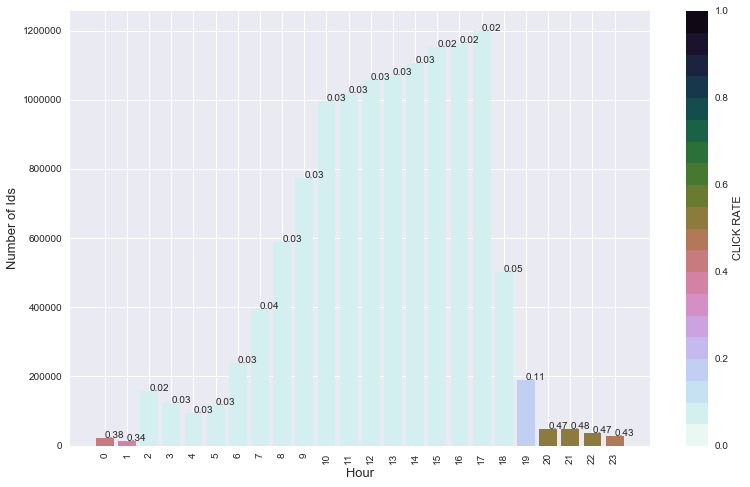

In [384]:
plots.plot_count_importance(df, 'hour', 'click', 'ID',annot=True)

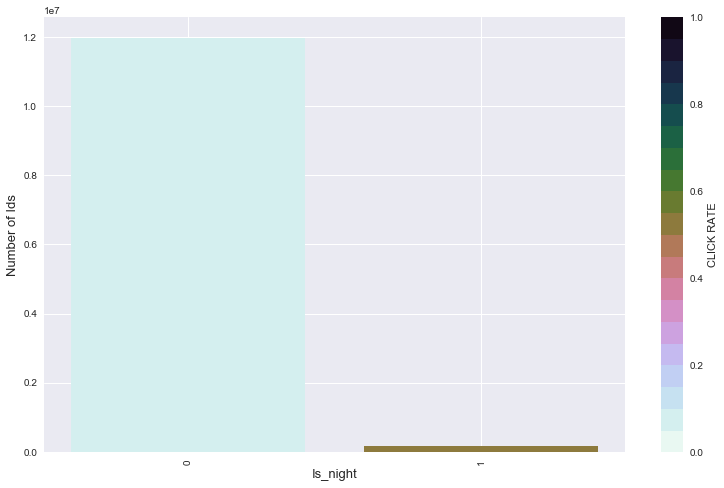

In [385]:
plots.plot_count_importance(df, 'is_night', 'click', 'ID')

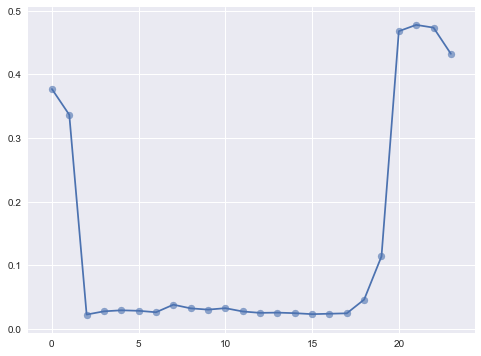

In [33]:
c = df.groupby('hour')['click'].mean()
plt.plot(c.index, c.values)
plt.scatter(c.index, c.values, alpha=0.6)
plt.show()

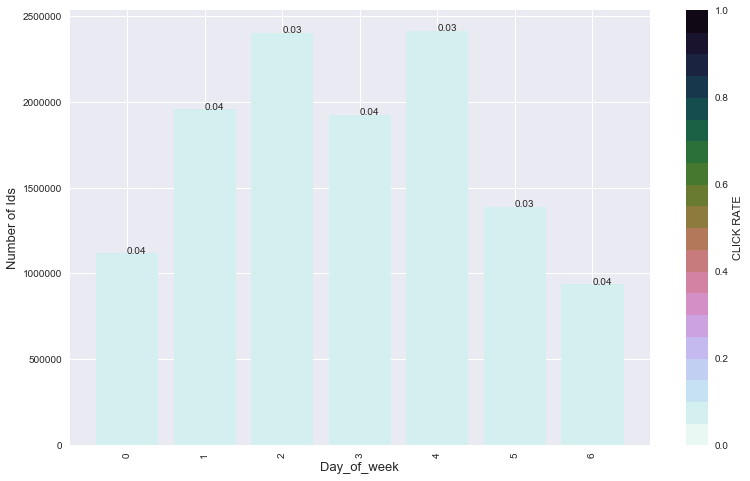

In [387]:
plots.plot_count_importance(df, 'day_of_week', 'click', 'ID', annot=True)

### SiteID

In [389]:
#number of sites
df.siteid.nunique()

219173

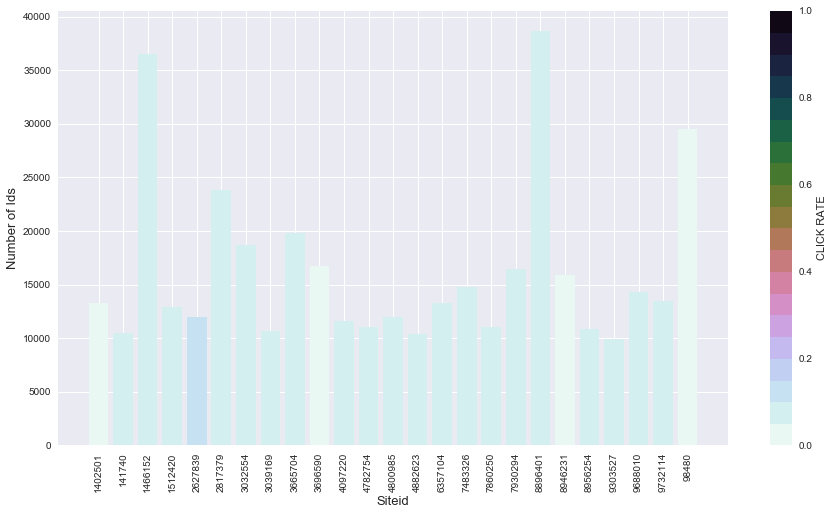

In [394]:
#checking the click rate on top 25 sites
top_25 = df.siteid.value_counts()[:25].index
plots.plot_count_importance(df.loc[df.siteid.isin(top_25)], 'siteid', 'click', 'ID', (15,8))

the site id doesn't have much impact.

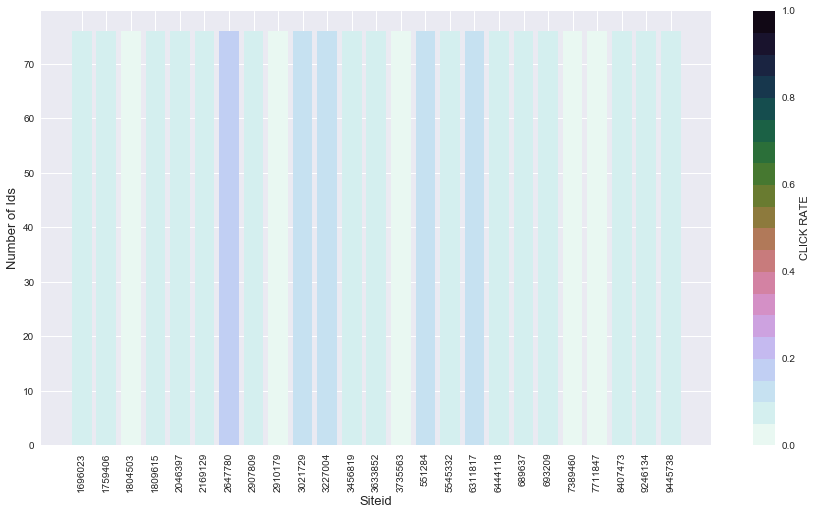

In [395]:
#checking the click rate on lower add showing sites
top_25 = df.siteid.value_counts()[20025:20050].index
plots.plot_count_importance(df.loc[df.siteid.isin(top_25)], 'siteid', 'click', 'ID', (15,8))

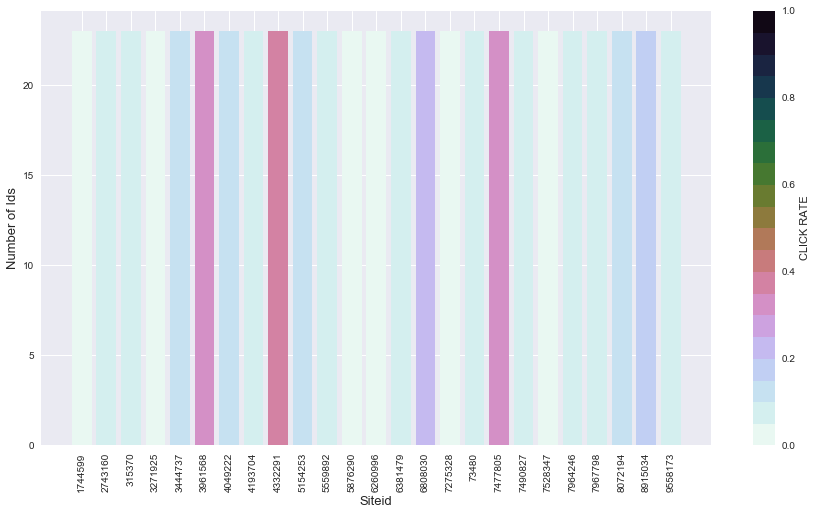

In [397]:
#checking the click rate on lower add showing sites
top_25 = df.siteid.value_counts()[50025:50050].index
plots.plot_count_importance(df.loc[df.siteid.isin(top_25)], 'siteid', 'click', 'ID', (15,8))

In [74]:
#Lets check according to how many adds are shown at a time on a site

In [75]:
top_25 = df.siteid.value_counts()[:25].index
df_temp = df.loc[df.siteid.isin(top_25)].reset_index(drop=True)

In [79]:
add_count = df_temp.groupby(['siteid','date', 'hour'])['ID'].count()

#### Rest feature . engineering afterwards of number of adds shown at a time

### offerid

In [398]:
df.offerid.nunique()

847510

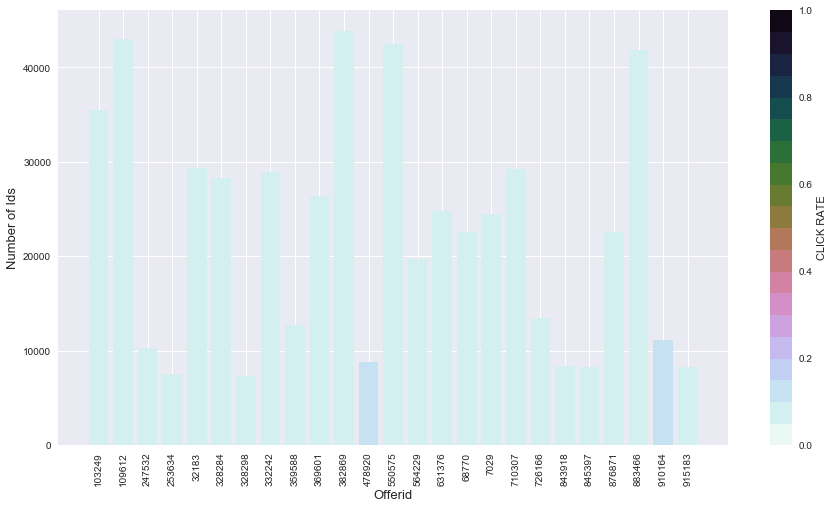

In [399]:
top_25 = df.offerid.value_counts()[:25].index
plots.plot_count_importance(df.loc[df.offerid.isin(top_25)], 'offerid', 'click', 'ID', (15,8))

### countrycode

In [400]:
df.countrycode.nunique()

6

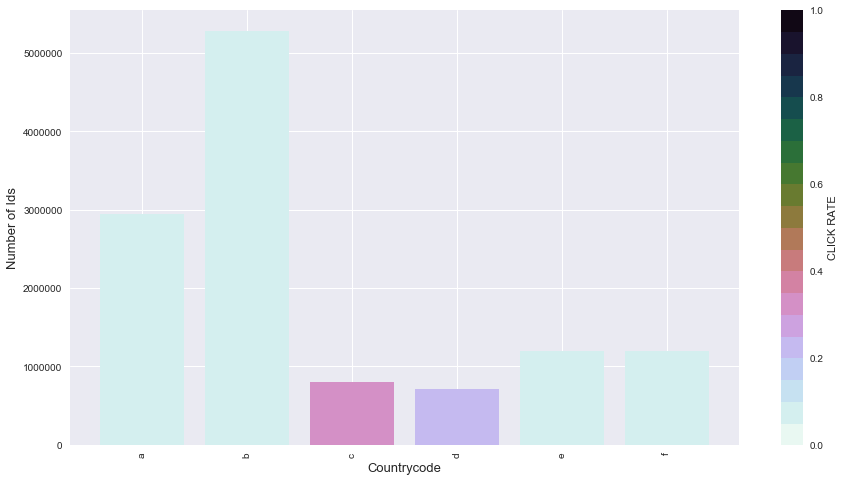

In [401]:
plots.plot_count_importance(df, 'countrycode', 'click', 'ID', (15,8))

In [123]:
df.columns

Index(['ID', 'datetime', 'siteid', 'offerid', 'category', 'merchant',
       'countrycode', 'browserid', 'devid', 'click', 'hour', 'day_of_week'],
      dtype='object')

In [124]:
from ak import plots

### Category

In [126]:
df.category.nunique()

271

In [129]:
df.category.unique()

array(['54916', '53956', '21407', '17118', '97852', '73362', '1678',
       '82877', '9764', '93286', '81229', '25491', '30580', '97863',
       '42227', '73248', '6906', '74711', '64452', '95113', '40339',
       '48498', '65251', '43612', '43897', '76239', '82396', '71531',
       '33638', '46955', '34670', '31365', '11837', '47327', '5602',
       '12052', '74802', '89522', '92704', '41706', '17714', '44388',
       '45287', '3037', '15912', '8467', '98552', '20665', '54343',
       '99178', '23576', '83091', '36768', '80554', '12211', '8675',
       '84974', '45620', '43347', '22518', '13255', '46450', '6747',
       '15124', '20322', '68947', '25516', '835', '56811', '87732',
       '80800', '37055', '54125', '41640', '67817', '904', '36610',
       '60316', '86652', '84987', '5194', '62949', '26849', '21380',
       '93188', '33287', '26962', '33949', '25015', '13412', '14960',
       '34489', '40050', '14345', '10345', '61302', '72276', '97807',
       '84144', '80319', '49810',

In [402]:
top_30_cat = df.category.value_counts()[:30].index

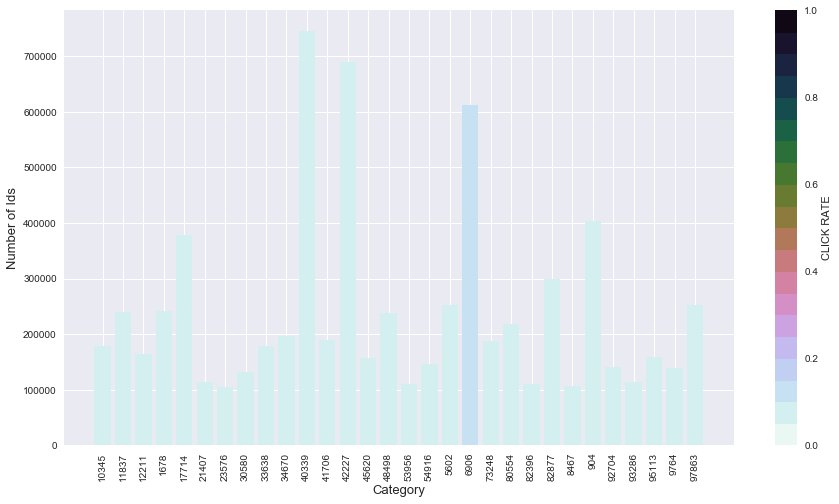

In [403]:
plots.plot_count_importance(df.loc[df.category.isin(top_30_cat)], 'category', 'click', 'ID', (15,8))

### Merchant

In [142]:
df.merchant.nunique()

697

In [143]:
df.merchant.unique()

array(['12817537', '59584425', '79474990', '96498275', '18243870',
       '43770446', '81758577', '66240359', '91808273', '1143033',
       '7122654', '48454212', '72161006', '73017084', '33505809',
       '40965804', '16370981', '98166279', '74868704', '67147700',
       '87807327', '83172146', '79055697', '96823930', '260443',
       '43526789', '61940782', '99510044', '2518327', '37135965',
       '65017662', '43452411', '80645978', '57977218', '72089744',
       '17990842', '9556126', '15961717', '66266506', '33664760',
       '80963339', '81055422', '70239921', '87726715', '92640312',
       '87903766', '55277834', '39507200', '96206255', '56008048',
       '7864011', '94555413', '50595884', '62201833', '50706198',
       '76532649', '1569330', '29624796', '94350426', '16340250',
       '3151081', '83960204', '47079934', '4000296', '54526992',
       '37767166', '30860214', '55358028', '4237811', '3402198',
       '71193712', '67274540', '91873245', '30349169', '26989642',
       

In [404]:
top_30_merchants = df.merchant.value_counts()[:30].index

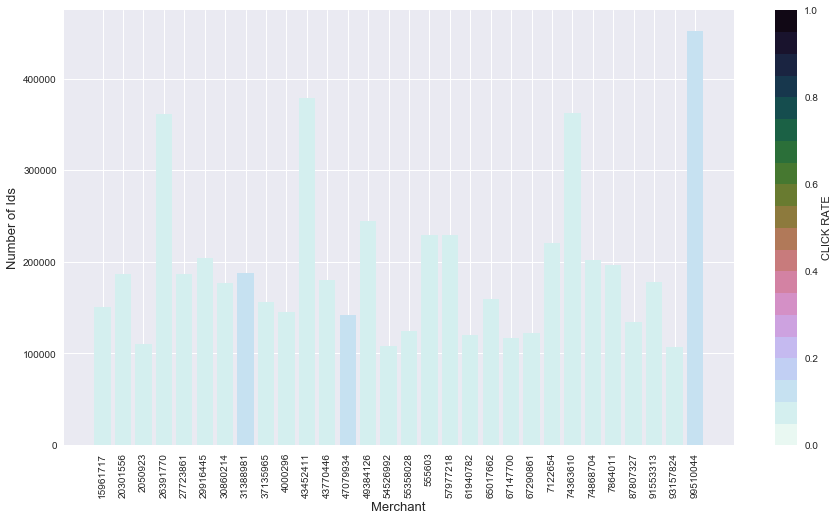

In [405]:
plots.plot_count_importance(df.loc[df.merchant.isin(top_30_merchants)], 'merchant', 'click', 'ID', (15,8))

### BrowserID

In [148]:
df.browserid.nunique()

11

In [149]:
df.browserid.unique()

array(['Internet Explorer', 'Edge', 'Firefox', nan, 'Mozilla Firefox',
       'Google Chrome', 'Mozilla', 'IE', 'InternetExplorer', 'Chrome',
       'Safari', 'Opera'], dtype=object)

In [153]:
#lets check now
df.browserid.unique(), df.browserid.nunique()

(array(['IE', 'Edge', 'Firefox', nan, 'Chrome', 'Safari', 'Opera'], dtype=object),
 6)

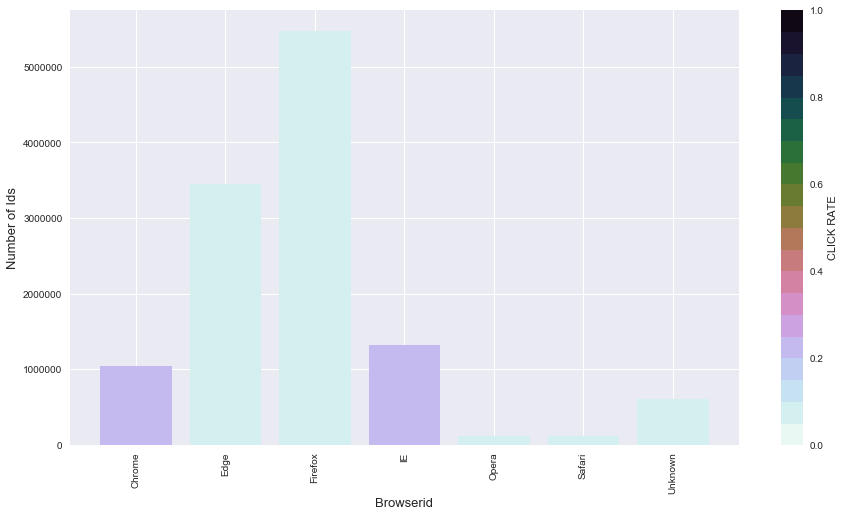

In [406]:
plots.plot_count_importance(df, 'browserid', 'click', 'ID', (15,8))

### DevID

In [159]:
df.devid.nunique()

3

In [160]:
df.devid.unique()

array(['Tablet', nan, 'Mobile', 'Desktop'], dtype=object)

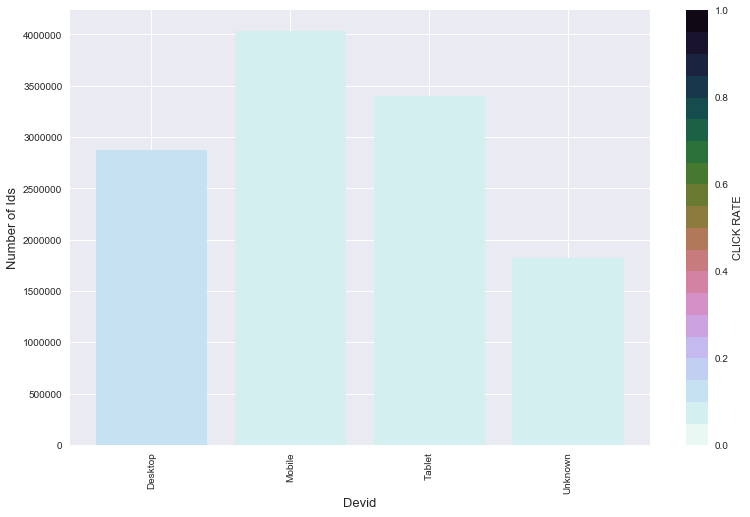

In [407]:
plots.plot_count_importance(df, 'devid', 'click', 'ID')

### More on siteid

In [521]:
ads_launched_together = df.groupby(['siteid', 'datetime'])['ID'].agg(['count'])

In [523]:
ads_launched_together = ads_launched_together.reset_index()

In [525]:
df = df.merge(ads_launched_together, 'left', ['siteid', 'datetime'])

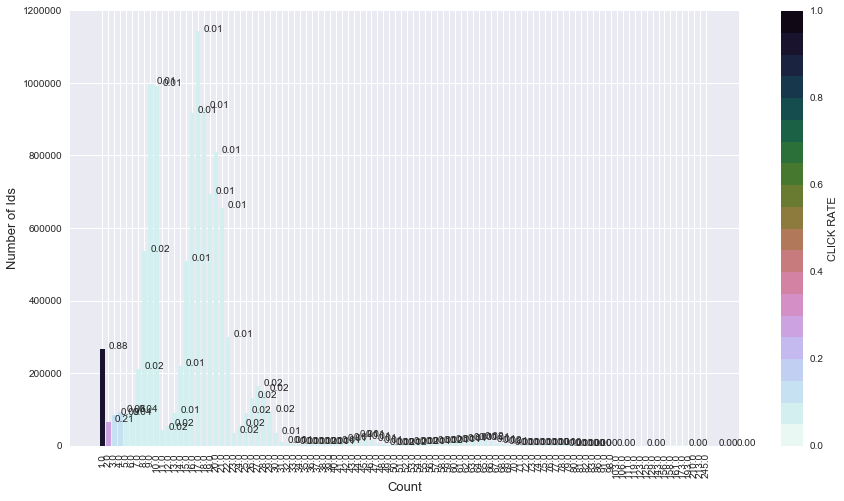

In [623]:
plots.plot_count_importance(df, 'count', 'click', 'ID', annot=True, size=(15, 8))

In [539]:
ads_launched_together_t = df_t.groupby(['siteid', 'datetime'])['ID'].agg(['count'])

In [540]:
ads_launched_together_t = ads_launched_together_t.reset_index()

In [542]:
df_t = df_t.merge(ads_launched_together_t, 'left', ['siteid', 'datetime'])

### More on offerid

In [646]:
c = df.groupby('count_offer')['click'].agg(['mean', 'count'])

In [674]:
offers_together_t = df_t.groupby(['offerid', 'datetime'])['ID'].agg(['count'])

In [675]:
offers_together_t = offers_together.reset_index()

In [676]:
df_t = df_t.merge(offers_together, 'left', ['offerid', 'datetime'], suffixes=('', '_offer'))

### More on category

In [648]:
category_together = df.groupby(['category', 'datetime'])['ID'].agg(['count'])

In [649]:
category_together = category_together.reset_index()

In [653]:
df = df.merge(category_together, 'left', ['category', 'datetime'], suffixes=('', '_category'))

In [656]:
c = df.groupby('count_category')['click'].agg(['count', 'mean'])
# plt.plot(c.index, c.values)
c

,count,mean
count_category,,
1,1466596,0.160768
2,889702,0.047081
3,659007,0.034041
4,615052,0.025104
5,577605,0.020819
6,543294,0.019949
7,472955,0.016693
8,468144,0.018065
9,612522,0.012920


In [677]:
category_together_t = df_t.groupby(['category', 'datetime'])['ID'].agg(['count'])

In [678]:
category_together_t = category_together_t.reset_index()

In [679]:
df_t = df_t.merge(category_together_t, 'left', ['category', 'datetime'], suffixes=('', '_category'))

### More on Merchant

In [732]:
#launched on how many sites together
#how much offer does merchant gives
#how frequently he gives offers

In [780]:
#not included yet
c = df.groupby(['merchant'])['offerid'].apply(lambda x: x.nunique())

In [782]:
c = c.reset_index()

In [786]:
df = df.merge(c, 'left', ['merchant'], suffixes=('', '_merchant_count'))

In [791]:
c = df.groupby('offerid_merchant_count')['click'].agg({'click':'mean', 'merchant':'count'})

(0, 1000)

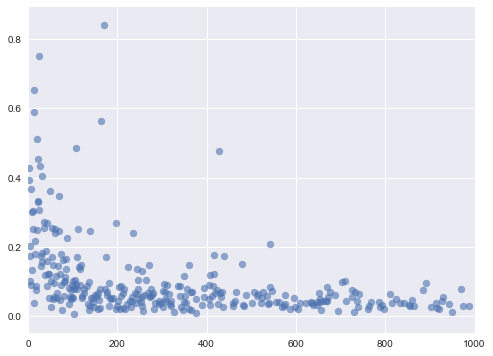

In [794]:
plt.scatter(c.index, c.click, alpha=0.6)
plt.xlim(0,1000)

In [795]:
#not included yet
c = df.groupby(['merchant'])['siteid'].apply(lambda x: x.nunique())

In [796]:
c = c.reset_index()

In [800]:
df = df.merge(c, 'left', ['merchant'], suffixes=('', '_merchant_count'))

In [801]:
c = df.groupby('siteid_merchant_count')['click'].agg({'click':'mean', 'merchant':'count'})

(0, 2000)

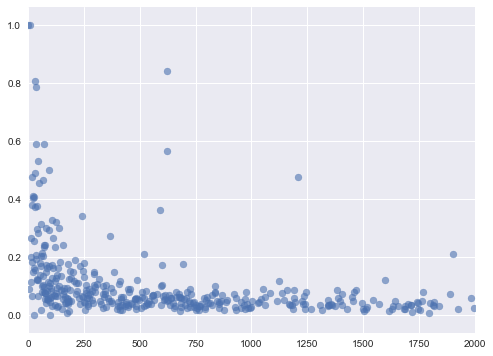

In [807]:
plt.scatter(c.index, c.click, alpha=0.6)
plt.xlim(0,2000)

In [818]:
c = df.groupby(['siteid'])['merchant'].apply(lambda x: x.nunique())

In [819]:
c = c.reset_index()

In [821]:
df = df.merge(c, 'left', ['siteid'], suffixes=('', '_siteid_count'))

In [827]:
c = df.groupby('merchant_siteid_count')['click'].agg(['mean', 'count'])

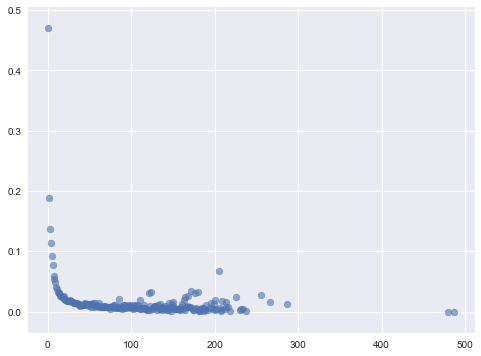

In [826]:
plt.scatter(c.index, c.values, alpha=0.6)

In [895]:
offer_onsite = df.groupby('siteid')['offerid'].apply(lambda x: x.nunique()).reset_index()

In [897]:
df = df.merge(offer_onsite, 'left', ['siteid'], suffixes=('', '_onsite'))

In [900]:
c = df.groupby('offerid_onsite')['click'].agg(['mean', 'count'])

(0, 100)

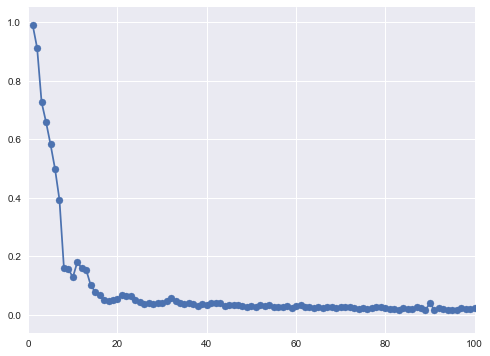

In [905]:
plt.plot(c.index, c['mean'])
plt.scatter(c.index, c['mean'])
plt.xlim(0,100)

In [960]:
#not included yet
c = df.groupby('siteid')['category'].apply(lambda x: x.nunique()).reset_index()

In [961]:
df = df.merge(c, 'left', ['siteid'], suffixes=('', '_siteid_count'))

In [963]:
c_ = df.groupby('category_siteid_count')['click'].agg(['mean', 'count'])

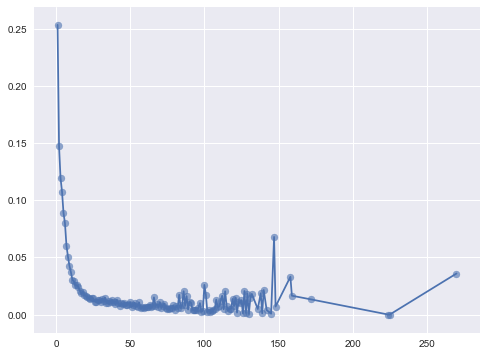

In [967]:
plt.plot(c_.index, c_['mean'])
plt.scatter(c_.index, c_['mean'], alpha=0.6)

In [944]:
#not included yet
c = df.groupby('category')['merchant'].apply(lambda x: x.nunique()).reset_index()

In [949]:
df = df.merge(c, 'left', ['category'], suffixes=('', '_category_count'))

In [950]:
c_ = df.groupby('merchant_category_count')['click'].agg(['mean', 'count'])

In [953]:
#not included yet
c = df.groupby('offerid')['merchant'].apply(lambda x: x.nunique()).reset_index()

In [957]:
df = df.merge(c, 'left', ['offerid'], suffixes=('', '_offer_count'))

In [958]:
c_ = df.groupby('merchant_offer_count')['click'].agg(['mean', 'count'])

In [959]:
c_

,mean,count
merchant_offer_count,,
1,0.035693,1829132
2,0.035558,3554663
3,0.037171,3240677
4,0.035887,2082736
5,0.033624,992710
6,0.038177,312967
7,0.040551,94128
8,0.033207,24362
9,0.065107,5299


In [ ]:
# feature 
# ads being launched at a time
# previous ad launched at
# how frequent is it showing ad`

### More on countrycode

In [9]:
#not included yet
unique_countries = df.groupby(['siteid', 'datetime'])['countrycode'].nunique()

In [11]:
unique_countries = unique_countries.reset_index()

In [13]:
df = df.merge(unique_countries, 'left', ['siteid', 'datetime'], suffixes=('', '_siteid_datetime_n'))

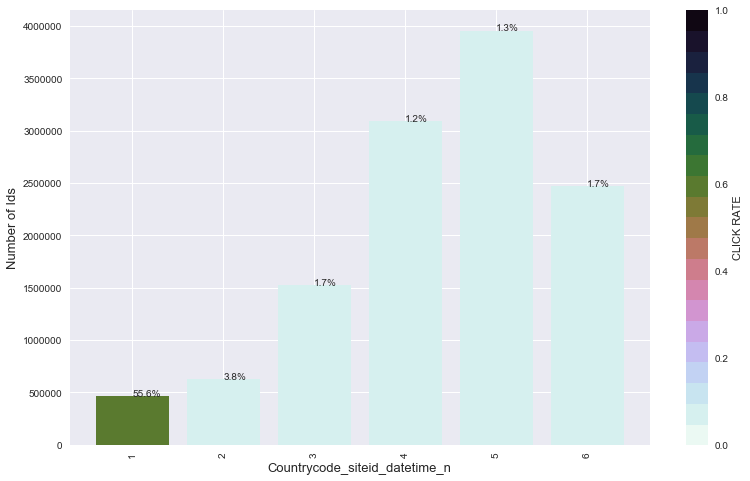

In [20]:
plots.plot_count_importance(df, 'countrycode_siteid_datetime_n', 'click', 'ID', annot=True)

In [21]:
#inlcuded, caused decrease on public LB
unique_countries_site = df.groupby(['siteid'])['countrycode'].nunique().reset_index()


In [25]:
df = df.merge(unique_countries_site, 'left', ['siteid'], suffixes=('', '_siteid_n'))

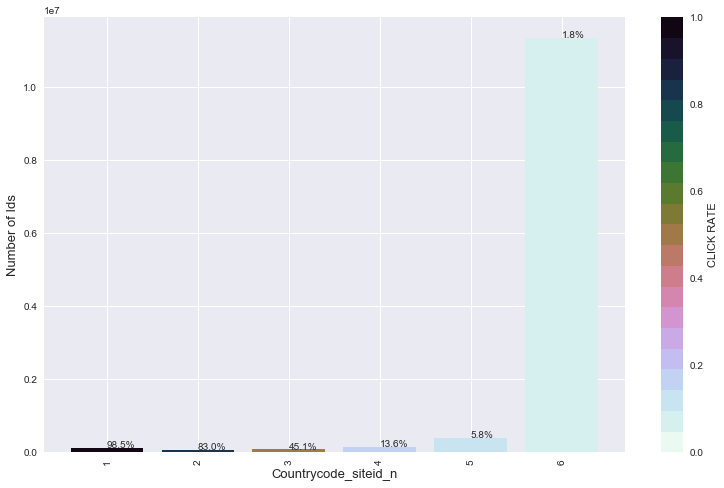

In [27]:
plots.plot_count_importance(df, 'countrycode_siteid_n', 'click', 'ID', annot=True)

In [32]:
df.groupby('countrycode_siteid_n')['click'].value_counts()

countrycode_siteid_n  click
1                     1.0        113860
                      0.0          1708
2                     1.0         50254
                      0.0         10329
3                     0.0         38675
                      1.0         31814
4                     0.0        125202
                      1.0         19646
5                     0.0        367277
                      1.0         22660
6                     0.0      11157405
                      1.0        198980
Name: click, dtype: int64

### exploring time pattern

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [100]:
df.groupby('siteid')['datetime'].nunique()>3

siteid
0         False
2         False
3         False
4         False
5         False
7          True
8         False
9          True
10        False
11        False
12        False
13        False
14        False
15        False
17         True
18        False
19        False
20        False
21        False
22        False
23        False
25        False
27        False
28         True
32        False
33         True
35         True
37        False
38        False
39         True
40        False
41        False
42        False
43        False
44        False
45        False
46        False
47        False
48        False
49        False
50        False
51        False
52        False
53        False
54        False
55        False
56        False
57         True
58        False
59        False
60        False
61        False
62         True
64        False
65        False
66         True
67        False
68         True
69        False
70        False
71        False
73        False
7

In [5]:
df_temp = df.loc[df['siteid']==7]

In [6]:
df_temp

,Unnamed: 0,ID,browserid,category,category_count_together,click,countrycode,datetime,day_of_week,devid,hour,is_night,merchant,merchant_count_together,merchant_siteid_count,offerid,offerid_count_together,siteid,siteid_count_together,offerid_siteid_count,category_siteid_count
5264109,5264109,IDHj7QK2B,2,19,11,0.0,1,2017-01-14 13:08:53,5,0,13,0,147,7,31.0,393449,1,7,8.0,95,25
5264117,5264117,ID4BpdqfE,3,19,11,0.0,0,2017-01-14 13:08:53,5,3,13,0,147,7,31.0,394248,1,7,8.0,95,25
5264119,5264119,IDMerPQTD,1,19,11,0.0,5,2017-01-14 13:08:53,5,2,13,0,43,2,31.0,465425,1,7,8.0,95,25
5264123,5264123,IDv9kAqkT,2,19,11,0.0,1,2017-01-14 13:08:53,5,0,13,0,147,7,31.0,55158,1,7,8.0,95,25
5264124,5264124,ID4iwPbLh,2,19,11,0.0,4,2017-01-14 13:08:53,5,0,13,0,147,7,31.0,238202,1,7,8.0,95,25
5264160,5264160,IDhXsdSa6,3,19,11,0.0,0,2017-01-14 13:08:53,5,2,13,0,147,7,31.0,81566,1,7,8.0,95,25
5264166,5264166,IDtJCRYTd,2,19,11,0.0,0,2017-01-14 13:08:53,5,0,13,0,147,7,31.0,307987,1,7,8.0,95,25
5264172,5264172,ID6pd1kPM,3,19,11,0.0,1,2017-01-14 13:08:53,5,1,13,0,147,7,31.0,857988,1,7,8.0,95,25
5432103,5432103,ID0iOkpAF,6,7,8,0.0,5,2017-01-14 14:13:47,5,2,14,0,584,6,31.0,449381,1,7,8.0,95,25
5432107,5432107,IDZEf1Fxd,2,7,8,0.0,0,2017-01-14 14:13:47,5,1,14,0,584,6,31.0,495169,1,7,8.0,95,25


In [105]:
import datetime, dateutil

In [110]:
(dateutil.parser.parse('2017-01-19 14:08:27')-dateutil.parser.parse('2017-01-14 16:01:01')).

4

In [8]:
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

In [11]:
tqdm_notebook().pandas()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [7]:
def get_ad_launched_after(df_temp):
    time_diff = (df_temp['datetime']-df_temp['datetime'].shift()).replace(0, np.nan).ffill()
    df_temp['ad_launched_after'] = (time_diff.dt.days*24*60)+((time_diff.dt.seconds)/60)
    return df_temp

In [13]:
%time ad_launched_after = df[['siteid', 'datetime']].drop_duplicates().groupby('siteid', as_index=False).progress_apply(get_ad_launched_after)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


219175/|/100%|| 219175/219175 [16:10<00:00, 253.05it/s]CPU times: user 16min 29s, sys: 46.7 s, total: 17min 16s
Wall time: 17min 16s


In [14]:
ad_launched_after.loc[ad_launched_after.siteid==273595, 'ad_launched_after'] = np.nan

In [18]:
df = df.merge(ad_launched_after, 'left', ['siteid', 'datetime'])

In [19]:
df.loc[df.siteid_count_together.isnull(), 'ad_launched_after'] = np.nan

In [34]:
df['ad_launched_after_cat'] = pd.cut(df['ad_launched_after'], bins=[-np.inf, 0, 2, 5, 10, 15, 30 ,45, 90, 120, 300]+list(np.arange(400, 16500, 500)))

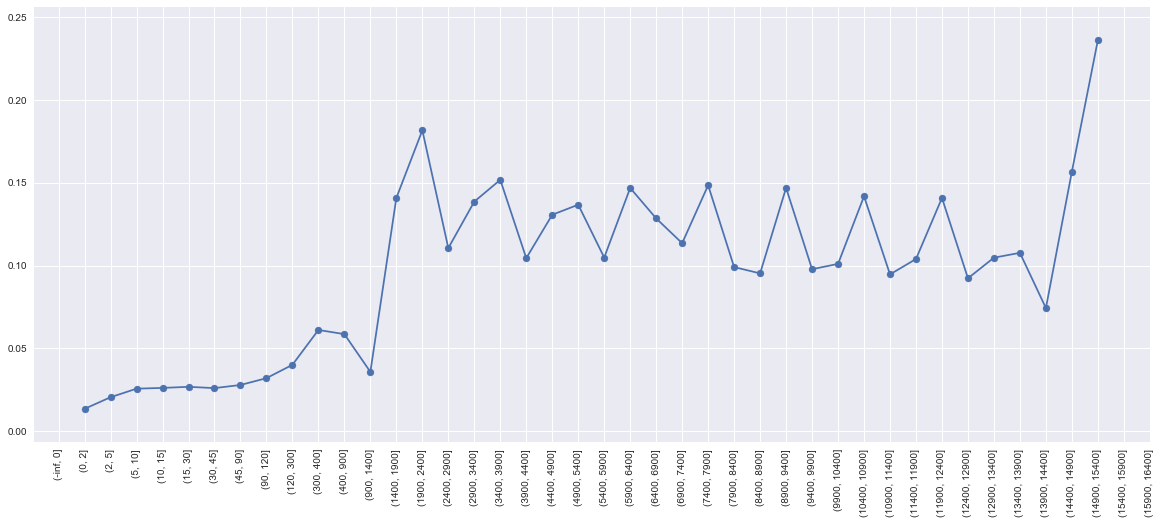

In [35]:
plt.figure(figsize=(20, 8))
c = df.groupby('ad_launched_after_cat')['click'].mean()
plt.scatter(range(len(c)), c.values)
plt.plot(range(len(c)), c.values)
plt.xticks(range(len(c)), c.index, rotation='vertical')
plt.show()

In [25]:
def get_ad_online_for(df_temp):
    time_diff = (df_temp['datetime'].shift(-1)-df_temp['datetime']).replace(0, np.nan).bfill()
    df_temp['ad_online_for'] = (time_diff.dt.days*24*60)+((time_diff.dt.seconds)/60)
    return df_temp

In [26]:
%time ad_online_for = df[['siteid', 'datetime']].drop_duplicates().groupby('siteid', as_index=False).progress_apply(get_ad_online_for)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



219175/|/100%|| 219175/219175 [17:10<00:00, 250.66it/s]
CPU times: user 16min 42s, sys: 1min 1s, total: 17min 43s
Wall time: 18min 15s


In [27]:
ad_online_for.loc[ad_online_for['siteid']==273595, 'ad_online_for'] = np.nan

In [28]:
df = df.merge(ad_online_for, 'left', ['siteid', 'datetime'])

In [41]:
df['ad_online_for_cat'] = pd.cut(df['ad_online_for'], bins=[-np.inf, 0, 2,5,10, 15, 30 ,45,90,120, 300]+list(np.arange(400, 16500, 500)))

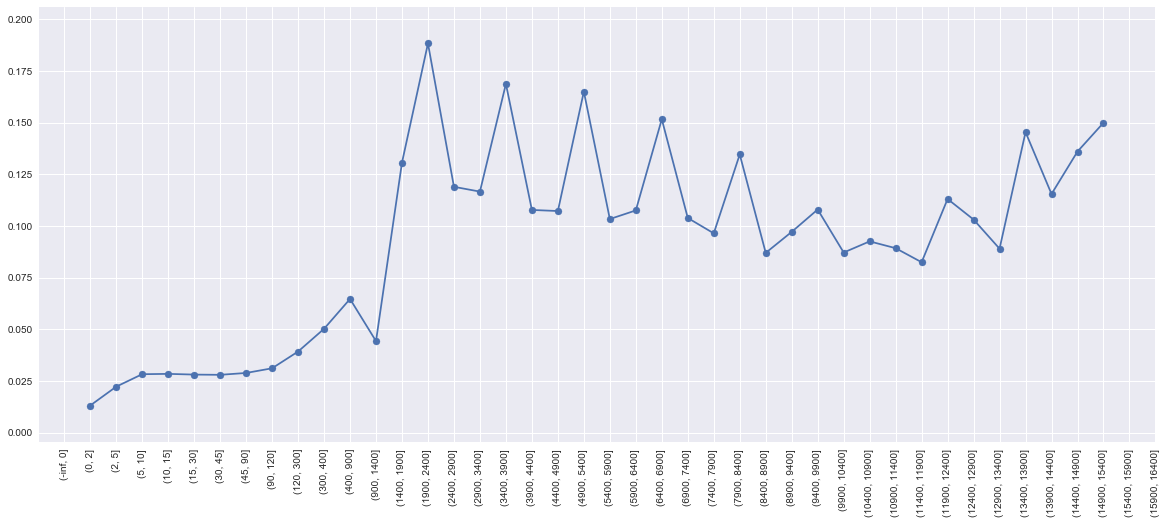

In [42]:
plt.figure(figsize=(20,8))
c = df.groupby('ad_online_for_cat')['click'].mean()
plt.scatter(range(len(c)), c.values)
plt.plot(range(len(c)), c.values)
plt.xticks(range(len(c)), c.index, rotation='vertical')
plt.show()

In [67]:
df_t['datetime'] = pd.to_datetime(df_t['datetime'])

In [68]:
df_t.sort_values(['datetime'], inplace=True)

In [69]:
def get_ad_launched_after(df_temp):
    time_diff = (df_temp['datetime']-df_temp['datetime'].shift()).replace(0, np.nan).ffill()
    df_temp['ad_launched_after'] = (time_diff.dt.days*24*60)+((time_diff.dt.seconds)/60)
    return df_temp

In [70]:
%time ad_launched_after = df_t[['siteid', 'datetime']].drop_duplicates().groupby('siteid').progress_apply(get_ad_launched_after)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


84894/|/100%|| 84894/84894 [06:10<00:00, 274.64it/s]
CPU times: user 6min 10s, sys: 18.1 s, total: 6min 28s
Wall time: 6min 26s


In [71]:
ad_launched_after.loc[ad_launched_after.siteid==273595, 'ad_launched_after'] = np.nan

In [72]:
df_t = df_t.merge(ad_launched_after, 'left', ['siteid', 'datetime'])

In [73]:
df_t['ad_launched_after_cat'] = pd.cut(df_t['ad_launched_after'], bins=[-np.inf, 0, 2, 5, 10, 15, 30 ,45, 90, 120, 300]+list(np.arange(400, 16500, 500)))

In [74]:
def get_ad_online_for(df_temp):
    time_diff = (df_temp['datetime'].shift(-1)-df_temp['datetime']).replace(0, np.nan).bfill()
    df_temp['ad_online_for'] = (time_diff.dt.days*24*60)+((time_diff.dt.seconds)/60)
    return df_temp

In [75]:
%time ad_online_for = df_t[['siteid', 'datetime']].drop_duplicates().groupby('siteid', as_index=False).progress_apply(get_ad_online_for)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


84894/|/100%|| 84894/84894 [06:10<00:00, 251.94it/s]
CPU times: user 6min 5s, sys: 23.8 s, total: 6min 29s
Wall time: 6min 27s


In [76]:
ad_online_for.loc[ad_online_for['siteid']==273595, 'ad_online_for'] = np.nan

In [77]:
df_t = df_t.merge(ad_online_for, 'left', ['siteid', 'datetime'])

In [78]:
df_t['ad_online_for_cat'] = pd.cut(df_t['ad_online_for'], bins=[-np.inf, 0, 2,5,10, 15, 30 ,45,90,120, 300]+list(np.arange(400, 16500, 500)))

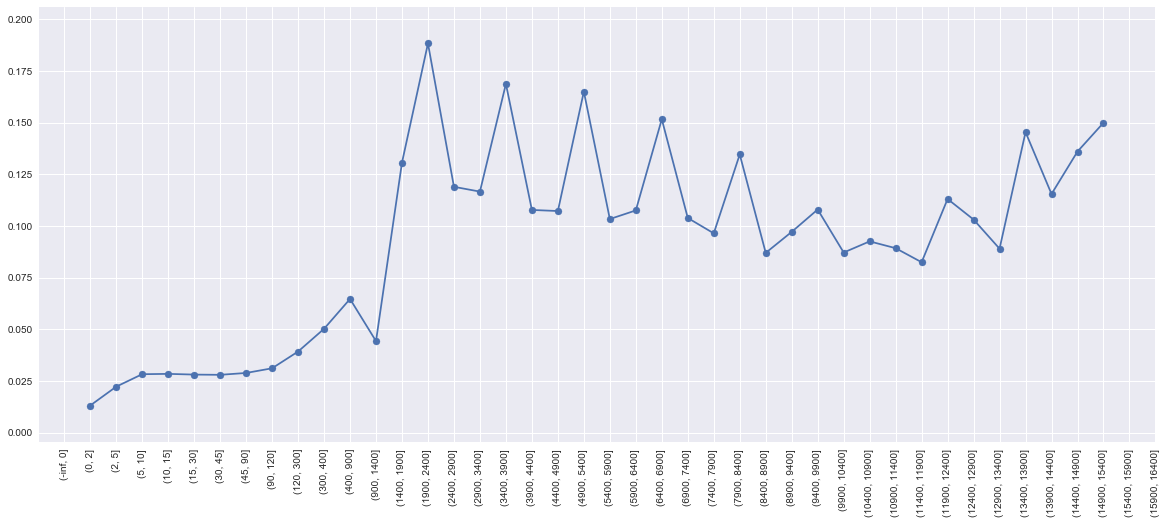

In [42]:
plt.figure(figsize=(20,8))
c = df.groupby('ad_online_for_cat')['click'].mean()
plt.scatter(range(len(c)), c.values)
plt.plot(range(len(c)), c.values)
plt.xticks(range(len(c)), c.index, rotation='vertical')
plt.show()

In [251]:
ad_launched_on_sites = df.groupby('datetime')['siteid'].nunique().reset_index()

In [253]:
df = df.merge(ad_launched_on_sites, 'left', 'datetime', suffixes=('', '_datetime_count'))

In [254]:
c = df.groupby('siteid_datetime_count')['click'].mean()

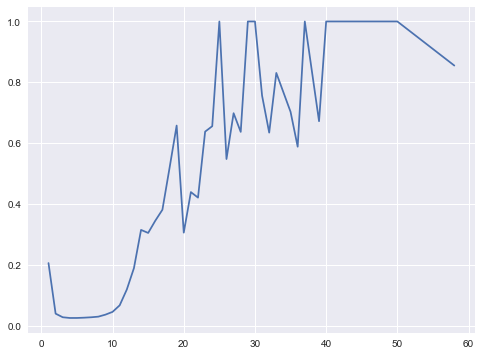

In [255]:
plt.plot(c.index, c.values)

In [251]:
ad_launched_on_sites = df.groupby('datetime')['siteid'].nunique().reset_index()

In [253]:
df = df.merge(ad_launched_on_sites, 'left', 'datetime', suffixes=('', '_datetime_count'))

In [254]:
c = df.groupby('siteid_datetime_count')['click'].mean()

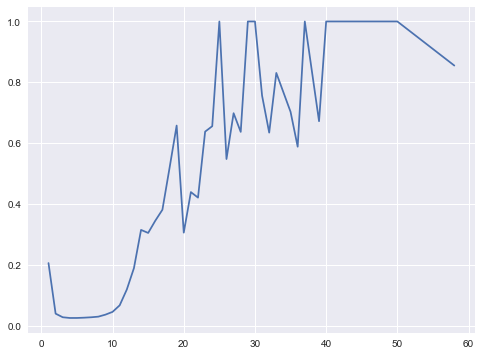

In [255]:
plt.plot(c.index, c.values)

In [256]:
offer_launched_together = df.groupby('datetime')['offerid'].nunique().reset_index()

In [260]:
df = df.merge(offer_launched_together, 'left', 'datetime', suffixes=('', '_datetime_count'))

In [263]:
c = df.groupby('offerid_datetime_count')['click'].agg(['mean', 'count'])

In [264]:
c

,mean,count
offerid_datetime_count,,
1,0.944765,90541
2,0.826519,47325
3,0.446574,36574
4,0.320050,28708
5,0.216365,24736
6,0.174441,21566
7,0.156441,17962
8,0.070862,38808
9,0.112668,21195


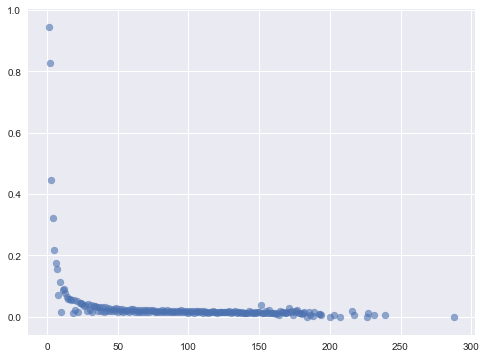

In [266]:
plt.scatter(c.index, c['mean'], alpha=0.6)

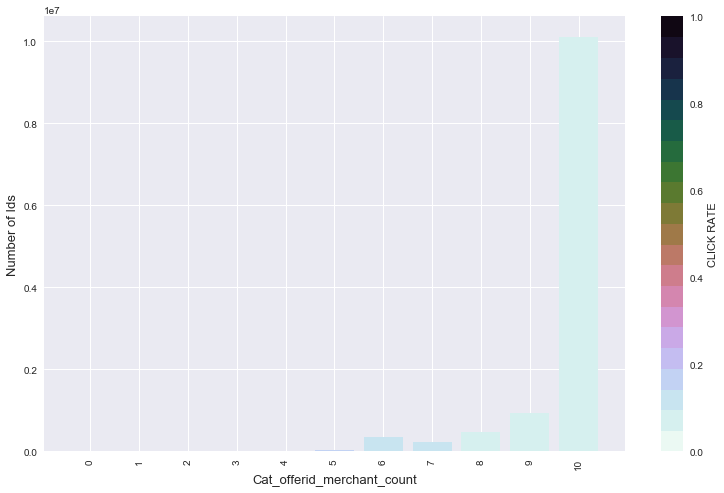

In [306]:
plots.plot_count_importance(df, 'Cat_offerid_merchant_count', 'click', 'ID')

### Building feature

In [408]:
df_new = pd.concat([df.loc[df.siteid.isin(df_t.siteid.unique())], df.loc[df.offerid.isin(df_t.offerid.unique())]]).drop_duplicates().reset_index(drop=True)

In [409]:
df_new.drop_duplicates(inplace=True)

In [410]:
df_new.click.mean()

0.03485371199566971

In [210]:
m_c = df_new.groupby('siteid')['click'].agg(['mean', 'count']).reset_index().sort_values('count', ascending=False)

In [211]:
m_c.columns = ['siteid', 'siteid_mean', 'siteid_count']

In [237]:
site_std = df_new.groupby('siteid')['click'].std().reset_index()

In [239]:
site_std.columns = ['siteid', 'siteid_std']

In [240]:
df_new = df_new.merge(site_std, 'left', 'siteid')

In [212]:
df_new.click.value_counts()

0    10491532
1      378874
Name: click, dtype: int64

In [213]:
df_new = df_new.merge(m_c, 'left', ['siteid'])

In [220]:
df_new.loc[df_new.siteid.isnull()]['click'].mean()

0.03588161795936545

In [219]:
df_new.click.value_counts()

0    10491532
1      378874
Name: click, dtype: int64

In [221]:
df_new.dropna(subset=['siteid'], inplace=True)

In [222]:
df_new.reset_index(drop=True, inplace=True)

In [223]:
df_t.siteid.nunique()

84892

In [171]:
df_t.offerid.nunique()

556519

In [168]:
#checking new siteid and offerid in test set
in_ = df_t.loc[df_t.siteid.isin(df.siteid.unique())].index
df_t.drop(in_)['siteid'].nunique()

54422

In [170]:
in_ = df_t.loc[df_t.offerid.isin(df.offerid.unique())].index
df_t.drop(in_)['offerid'].nunique()

36843

In [389]:
#for siteid
site_mean = df.groupby(['siteid'])['click'].mean().reset_index()

site_mean = site_mean.sort_values('click', ascending=False).reset_index(drop=True)

In [395]:
sm_parts = np.array_split(site_mean, 500)

In [396]:
site_mean_ = pd.DataFrame()
for i in range(500):
    curr = sm_parts[i]
    curr['siteid_cat'] = i
    site_mean_ = site_mean_.append(curr)
    print(i, end='\r')

In [421]:
#for offerid
offer_mean = df.groupby(['offerid'])['click'].mean().reset_index()

offer_mean = offer_mean.sort_values('click', ascending=False).reset_index(drop=True)

In [422]:
sm_parts = np.array_split(offer_mean, 500)

In [423]:
offer_mean_ = pd.DataFrame()
for i in range(500):
    curr = sm_parts[i]
    curr['offerid_cat'] = i
    offer_mean_ = offer_mean_.append(curr)
    print(i, end='\r')

In [399]:
df = df.merge(site_mean_[['siteid', 'siteid_cat']], 'left', 'siteid')

In [424]:
df = df.merge(offer_mean_[['offerid', 'offerid_cat']], 'left', 'offerid')

In [87]:
#feature idea, categorize the siteid according to clickrate and give that id as feature
#day of week is sunday type

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x391a477f0>>
Traceback (most recent call last):
  File "/Users/aakash/anaconda3/anaconda/xgboost/python-package/xgboost/core.py", line 337, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


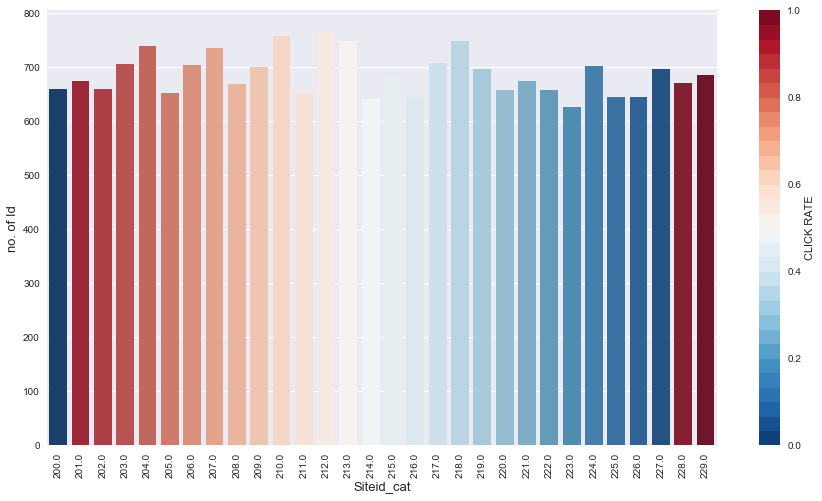

In [402]:
plots.plot_count_importance(df.loc[df.siteid_cat.isin(range(200,230))], 'siteid_cat', 'click', 'ID', (15,8))

In [403]:
df_t = df_t.merge(site_mean_[['siteid', 'siteid_cat']], 'left', 'siteid')

In [425]:
df_t = df_t.merge(offer_mean_[['offerid', 'offerid_cat']], 'left', 'offerid')

In [426]:
df_t.columns

Index(['ID', 'datetime', 'siteid', 'offerid', 'category', 'merchant',
       'countrycode', 'browserid', 'devid', 'hour', 'day_of_week', 'click',
       'siteid_cat', 'offerid_cat'],
      dtype='object')

In [ ]:
# Since we're doing undersampling a lot of siteid, offerid may be lost which may appear in 

## Model

In [13]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'ID', 'browserid', 'category',
       'category_count_together', 'click', 'countrycode', 'datetime',
       'day_of_week', 'devid', 'hour', 'is_night', 'merchant',
       'merchant_count_together', 'merchant_siteid_count', 'offerid',
       'offerid_count_together', 'siteid', 'siteid_count_together',
       'offerid_siteid_count', 'category_siteid_count', 'ad_launched_after',
       'ad_launched_after_cat', 'ad_online_for', 'ad_online_for_cat',
       'offerid_datetime_count'],
      dtype='object')

In [14]:
df_t.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'ID', 'browserid', 'category',
       'category_count_together', 'click', 'countrycode', 'datetime',
       'day_of_week', 'devid', 'hour', 'is_night', 'merchant',
       'merchant_count_together', 'merchant_siteid_count', 'offerid',
       'offerid_count_together', 'siteid', 'siteid_count_together',
       'offerid_siteid_count', 'category_siteid_count',
       'offerid_datetime_count'],
      dtype='object')

In [18]:
to_drop = ['Unnamed: 0', 'Unnamed: 0.1','ID', 'datetime', 'click', 'is_night', 'ad_launched_after',
       'ad_launched_after_cat', 'ad_online_for', 'ad_online_for_cat', 'category_siteid_count']

In [19]:
predictors = df.columns.drop(to_drop)

In [20]:
predictors

Index(['browserid', 'category', 'category_count_together', 'countrycode',
       'day_of_week', 'devid', 'hour', 'merchant', 'merchant_count_together',
       'merchant_siteid_count', 'offerid', 'offerid_count_together', 'siteid',
       'siteid_count_together', 'offerid_siteid_count',
       'offerid_datetime_count'],
      dtype='object')

In [688]:
df.isnull().sum()

ID                      0
browserid               0
category                0
click                   0
count             1212515
countrycode             0
datetime                0
day_of_week             0
devid                   0
hour                    0
is_night                0
merchant                0
offerid                 0
siteid                  0
count_offer             0
count_category          0
dtype: int64

In [90]:
df_all = pd.concat([df, df_t])

In [247]:
df_all[predictors].dtypes

KeyboardInterrupt: 

In [105]:
predictors

Index(['browserid', 'category', 'category_count_together', 'countrycode',
       'day_of_week', 'devid', 'hour', 'merchant', 'merchant_count_together',
       'merchant_siteid_count', 'offerid', 'offerid_count_together',
       'siteid_count_together', 'offerid_siteid_count',
       'ad_launched_after_cat', 'ad_online_for_cat'],
      dtype='object')

In [113]:
le = LabelEncoder()
for col in predictors:
    if df_all[col].dtype=='O' or df_all[col].dtype=='category':
        print(col)
        try:
            df_all[col] = le.fit_transform(df_all[col])
        except TypeError:
            df_all[col] = le.fit_transform(df_all[col].fillna('NAN'))

TypeError: data type "category" not understood

In [114]:
df['ad_online_for_cat'] = le.fit_transform(df.ad_online_for_cat.astype(str).fillna('NAN'))
df_t['ad_online_for_cat'] = le.transform(df_t.ad_online_for_cat.astype(str).fillna('NAN'))

In [94]:
df = df_all.loc[df_all.ID.isin(df.ID.unique())].reset_index(drop=True)

In [95]:
df_t = df_all.loc[df_all.ID.isin(df_t.ID.unique())].reset_index(drop=True)

In [21]:
df.dtypes

Unnamed: 0                   int64
Unnamed: 0.1                 int64
ID                          object
browserid                    int64
category                     int64
category_count_together      int64
click                      float64
countrycode                  int64
datetime                    object
day_of_week                  int64
devid                        int64
hour                       float64
is_night                     int64
merchant                     int64
merchant_count_together      int64
merchant_siteid_count      float64
offerid                      int64
offerid_count_together       int64
siteid                       int64
siteid_count_together      float64
offerid_siteid_count         int64
category_siteid_count        int64
ad_launched_after          float64
ad_launched_after_cat       object
ad_online_for              float64
ad_online_for_cat           object
offerid_datetime_count       int64
dtype: object

In [878]:
del df_all

In [96]:
import imp

In [619]:
def print_scores(y_true, y_pred, get=False):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f_score = metrics.f1_score(y_true, y_pred)
    print(metrics.confusion_matrix(y_true, y_pred))
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    print('Accuarcy = {0:.3f}\tPrecision = {1:.3f}\tRecall = {2:.3f}\tF_Score = {3:.3f}\tROC_AUC = {4:.3f}'.format(accuracy, precision, recall, f_score, roc_auc))
    if get:
        return accuracy, precision, recall, f_score

def run_cv(clf_, df_, predictors, dv, split_column, balance_ratio, stop_after=2, balance=None,):
    all_scores = []
    count = 0
    kf = KFold(len(df_))
    for train_i, cv_i in kf:
        df_train = df_.loc[train_i]
        print('Train ratio before balancing =',df_train[dv].mean())
        n_ones = df_train[dv].value_counts()[1]
        n_zeroes = df_train[dv].value_counts()[0]
        if n_ones>n_zeroes:
#             n_ones_sample = int(df_train.shape[0]*balance_ratio)
            df_train = pd.concat([df_train.loc[df_train[dv]==1].sample(n_zeroes), df_train.loc[df_train[dv]==0]]).reset_index(drop=True)
        elif n_zeroes>n_ones:
#             n_zeroes_sample = int(df_train.shape[0]*balance_ratio)
            df_train = pd.concat([df_train.loc[df_train[dv]==0].sample(n_ones), df_train.loc[df_train[dv]==1]]).reset_index(drop=True)
        print('Train ratio after balancing =',df_train[dv].mean())
        df_cv = df_.loc[cv_i]
        df_train.reset_index(drop=True, inplace=True)
        print('Test ratio =',df_cv[dv].mean())
#         df_train_c = df_train.sample(frac=0.6)
        clf_.fit(df_train[predictors], df_train[dv])
        preds = clf_.predict_proba(df_cv[predictors])[:,1]
#         print(metric.gain_chart(df_cv, preds, dv))
        preds_cl = clf_.predict(df_cv[predictors])
#         preds[preds>=0.5] = 1
#         preds[preds<0.5] = 0
        count = count+1
        print(count)
        if count>stop_after:
            break
        all_scores.append(print_scores(df_cv[dv],preds_cl, get=True))
    return clf_,df_cv, preds, all_scores

In [99]:
from sklearn.model_selection import GroupKFold

In [288]:
xgb = xgboost.XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.015)

In [69]:
xgb = RandomForestClassifier(n_estimators=300, max_depth=3, max_features='sqrt', criterion='entropy', verbose=2, n_jobs=-1)

In [333]:
clf, df_cv, preds, scores = run_cv(xgb, df, predictors, 'click', 'ID', 0.05, stop_after=0)

Train ratio before balancing = 0.03607755583904987
Train ratio after balancing = 0.5
Test ratio = 0.03590738066361389
199


In [661]:
df_cv = df.sample(3700000)

In [662]:
df_train = df.drop(df.loc[df.ID.isin(df_cv.ID.unique())].index).reset_index(drop=True)

In [663]:
n_ones = df_train.click.value_counts()[1]

In [664]:
m = 0

In [665]:
df_train = pd.concat([df_train.loc[df_train.click==0].sample(n_ones+int(m*n_ones)), df_train.loc[df_train.click==1]]).reset_index(drop=True)

In [666]:
df_train.click.mean()

0.5

In [667]:
xgb.fit(df_train[predictors], df_train['click'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [30]:
imp = pd.Series(data=xgb.feature_importances_, index=predictors).sort_values()

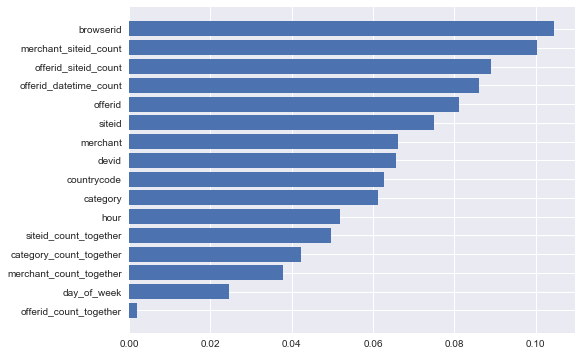

In [31]:
plt.barh(range(len(imp)), imp.values)
plt.yticks(range(len(imp)), imp.index)
plt.show()

In [670]:
preds = xgb.predict_proba(df_cv[predictors])

In [671]:
preds_cl = xgb.predict(df_cv[predictors])

In [672]:
metrics.roc_auc_score(df_cv['click'], preds[:,1])

0.98517082171695813

In [296]:
fpr, tpr, thresholds  = metrics.roc_curve(df_cv['click'] ,preds[:,1])

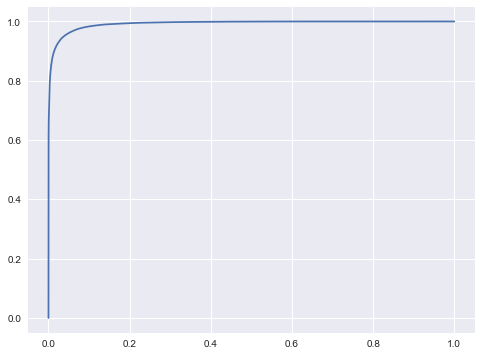

In [297]:
plt.plot(fpr, tpr)
# plt.scatter(fpr, thresholds)

In [673]:
print_scores(df_cv['click'], preds_cl)

[[3399200  167976]
 [   9662  123162]]
Accuarcy = 0.952	Precision = 0.423	Recall = 0.927	F_Score = 0.581	ROC_AUC = 0.940


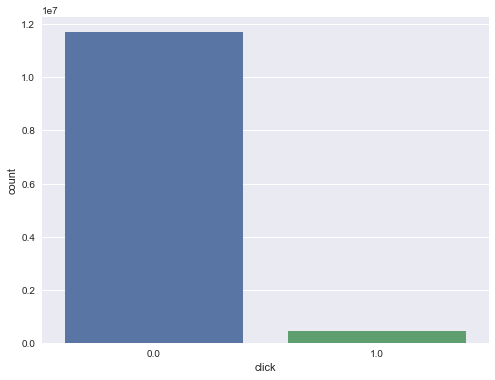

In [22]:
sns.countplot(df.click)
plt.show()

In [58]:
df.click.value_counts()

0.0    11700596
1.0      437214
Name: click, dtype: int64

In [84]:
df_train = pd.concat([df.loc[df.click==0].sample(437000), df.loc[df.click==1]]).reset_index(drop=True)

In [85]:
df_train.click.value_counts()

1.0    437214
0.0    437000
Name: click, dtype: int64

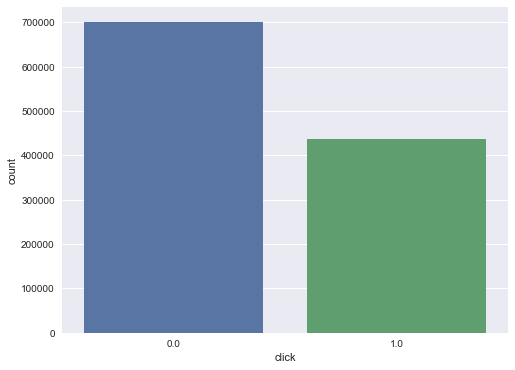

In [71]:
sns.countplot(df_train.click)

In [22]:
from sklearn.neural_network import MLPClassifier

In [23]:
xgb = MLPClassifier((50, 38))

In [67]:
xgb = xgboost.XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.015)

In [42]:
predictors = predictors.drop(['category_siteid_count'])

In [43]:
predictors

Index(['browserid', 'category', 'category_count_together', 'countrycode',
       'day_of_week', 'devid', 'hour', 'merchant', 'merchant_count_together',
       'merchant_siteid_count', 'offerid', 'offerid_count_together',
       'siteid_count_together', 'offerid_siteid_count'],
      dtype='object')

In [240]:
all_preds = []

In [243]:
for i in range(500):
    print(i)
    df_c = df_train.sample(100000)
    print('ratio =',df_c.click.mean())
    xgb.fit(df_c[predictors], df_c['click'])

    preds = xgb.predict_proba(df_t[predictors])[:,1]

    all_preds.append(preds)

0
ratio = 0.4679
199
ratio = 0.46523


KeyboardInterrupt: 

In [150]:
all_pred_df = []
for i in all_preds:
    all_pred_df.append(pd.DataFrame(i))

In [156]:
df_all_preds = pd.concat(all_pred_df, axis=1)

In [160]:
pred_ensemble = df_all_preds.mean(1)

In [174]:
df_train_s = df_train.sample(100000)

In [64]:
from tqdm import tqdm_notebook

In [166]:
df_train_s.click.mean()

0.4994166666666667

In [95]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.015, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [181]:
# best params
param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.025
param['max_depth'] = 10
param['silent'] = 0
#param['num_class'] = 2
param['eval_metric'] = 'auc'
param['min_child_weight'] = 3
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 100
param['booster']='gbtree'

In [118]:
data = xgboost.DMatrix(np.array(df_train_s[predictors]) , label = np.array(df_train_s['click']))

In [183]:
clf = xgboost.train(param, xgboost.DMatrix(np.array(df_train_s[predictors]) , label = np.array(df_train_s['click'])), num_boost_round=500)

In [184]:
%time preds = clf.predict(xgboost.DMatrix(np.array(df_t[predictors])))

CPU times: user 23min 32s, sys: 13.1 s, total: 23min 46s
Wall time: 24min 1s


In [185]:
df_t['click'] = preds

In [186]:
df_t.click.head()

0    0.001108
1    0.000799
2    0.211611
3    0.002851
4    0.006419
Name: click, dtype: float32

In [992]:
df_t.click.head()

0    0.012267
1    0.008219
2    0.101529
3    0.007922
4    0.009452
Name: click, dtype: float32

In [187]:
df_t[['ID', 'click']].to_csv('hackerearth_predict_click/sub35_100kdata_depth10_eta_025_1000trees.csv', index=False)